# 水肿体积随时间变化曲线 拟合+计算残差   
> a)  请根据“表2”前100个患者（sub001至sub100）的水肿体积（ED_volume）和重复检查时间点，构建一条全体患者水肿体积随时间进展曲线   
（x轴：发病至影像检查时间，y轴：水肿体积，y=f(x)），   
计算前100个患者（sub001至sub100）真实值和所拟合曲线之间存在的残差。   
结果填写规范：记录残差，填写位置“表4”F字段（残差（全体））。

## 读入数据   
理论上此处需要使用三个文件：   
- 表1-患者列表及临床信息（用于确定发病时间）
- 表2-患者影像信息血肿及水肿的体积及位置（用于获取每次检查时的肿块体积和检查流水号）
- 附表1-检索表格-流水号vs时间（基于检查流水号获取检查时间点）   

用 Q1a 的中间结果替代时间间隔数据更快一些

In [1]:
import pandas as pd
import math

In [6]:
tab_1 = pd.read_excel('~/shumo/metadata/表1-患者列表及临床信息.xlsx')
tab_1 = tab_1.rename(columns={'Unnamed: 0': 'ID'})

# tab_2 = pd.read_excel('~/shumo/metadata/表2-患者影像信息血肿及水肿的体积及位置.xlsx')

ann_tab = pd.read_excel('~/shumo/metadata/附表1-检索表格-流水号vs时间(1).xlsx')

In [9]:
# 沿用 Q1a 的处理代码获取 ED_volume
tab2_dict = {}
for i, sheet_name in enumerate(['首次', '随访1', '随访2', '随访3', '随访4', '随访5', '随访6', '随访7', '随访8']):
    if sheet_name == '首次':
        col = '首次检查流水号'
    else:
        col = sheet_name + '流水号'

    tab2_dict[i] = pd.read_excel('~/shumo/metadata/表2-患者影像信息血肿及水肿的体积及位置.xlsx', sheet_name=sheet_name, usecols=['ID', col, 'ED_volume'])

In [65]:
# 从 Q1a 获取一个中间结果：包含发病时间和每次检查的时间间隔
tab2_cmp = pd.read_excel("~/shumo/Q1/Q1a/processed/Q1a_record.xlsx", usecols=['ID', 'interval_1', 'interval_2','interval_3','interval_4','interval_5','interval_6','interval_7','interval_8'])

In [77]:
tab2_cmp

,ID,interval_1,interval_2,interval_3,interval_4,interval_5,interval_6,interval_7,interval_8
0,sub001,8.268333,132.108333,259.737500,425.538333,NaN,NaN,NaN,NaN
1,sub002,14.923333,69.221944,448.016389,1119.191944,NaN,NaN,NaN,NaN
2,sub003,9.522500,39.595833,NaN,NaN,NaN,NaN,NaN,NaN
3,sub004,16.974167,83.845278,227.501111,NaN,NaN,NaN,NaN,NaN
4,sub005,26.467500,97.943056,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
155,sub156,24.881944,125.615833,293.317222,NaN,NaN,NaN,NaN,NaN
156,sub157,1.366667,7.116667,20.066667,NaN,NaN,NaN,NaN,NaN
157,sub158,18.383333,71.300000,308.650000,NaN,NaN,NaN,NaN,NaN
158,sub159,26.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 获取每个时间点下的水肿体积

In [95]:
# 获得每个病人每次测量的水肿体积和对应时间间隔（指从发病到该次检测的时间间隔）
# 指计算前 100 个患者

patient_ED_dict = dict()

for patient in tab_1["ID"].tolist()[:100]:
    
    patient_ED_dict[patient] = []
    
    # 获取时间间隔
    first_interval = tab_1.loc[tab_1["ID"] == patient]["发病到首次影像检查时间间隔"].values[0]
    interval_time = [first_interval] + tab2_cmp.loc[tab2_cmp['ID'] == patient].values.tolist()[0][1:]
    
    # 获取每次的水肿数量
    for check in range(9): # 最多只有1次检查+8次随访记录
        
        ed_v = tab2_dict[check].loc[tab2_dict[check]["ID"] == patient].values[0][2]
        
        # 如果此次随访已没有记录则跳出
        if pd.isna(ed_v):
            break
        
        ed_v = ed_v
        patient_ED_dict[patient].append((interval_time[check], ed_v))

In [98]:
# 保存数据
pd.to_pickle(patient_ED_dict, "patient_ED_dict.pkl")

## 时序数据可视分析

In [3]:
patient_ED_dict = pd.read_pickle("../processed/patient_ED_dict.pkl")

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
time = []
vol = []
for person in patient_ED_dict:
    seq = patient_ED_dict[person]
    # 时间间隔
    time += [i[0] for i in seq]
    # 体积
    vol += [i[1] / 1000 for i in seq] # 单位统一到 ml

In [7]:
%matplotlib inline

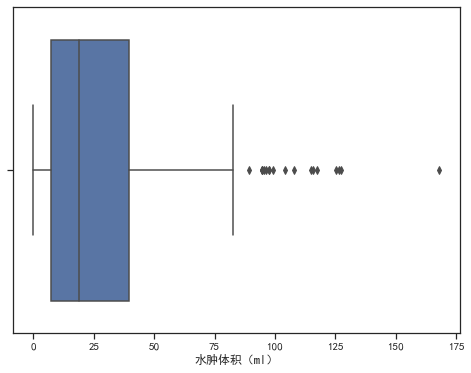

In [175]:
# 单变量分析：水肿的分布
plt.close()

plt.figure(figsize=(8, 6))
sns.boxplot(x=vol)
plt.xlabel('水肿体积（ml）')
# plt.ylabel('分布频率')

plt.show()

In [172]:
# 计算条形图相关参数
mean = np.mean(vol)  # 平均值
median = np.median(vol)  # 中位数
std = np.std(vol)  # 标准差
min_value = np.min(vol)  # 最小值
max_value = np.max(vol)  # 最大值

# 输出条形图相关参数
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)
print("Min Value:", min_value)
print("Max Value:", max_value)

Mean: 26.561
Median: 18.988999999999997
Standard Deviation: 26.065960710900764
Min Value: 0.0
Max Value: 168.138


In [8]:
# 分样本散点图
pat = [i+1 for i in range(100)]

y_seq = [] # y轴数据是患者序号
time_seq = [] # 仍然作为 y轴
val_seq = [] # 作为散点的数值存在

for person in patient_ED_dict:
    seq = patient_ED_dict[person]
    # 时间间隔
    time_seq += [i[0] for i in seq]
    # 体积
    val_seq += [i[1] / 1000 for i in seq] # 单位统一到 ml
    # 患者序号
    y_seq += [int(person[3:]) for i in range(len(seq))]

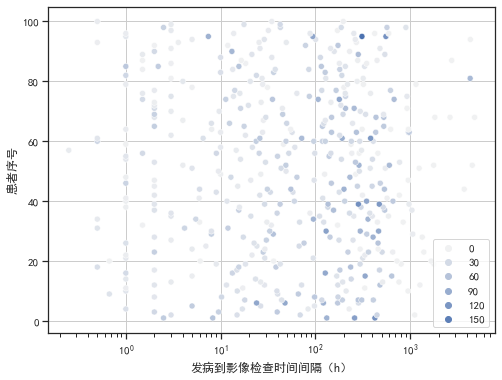

In [163]:
# 双变量分析：分样本散点图
# 横坐标 检测到发病的时间点
# 纵坐标 患者序号
# 散点颜色 水肿体积（ml）
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))

sns.color_palette("light:b", as_cmap=True)

sns.scatterplot(x=time_seq, y=y_seq, hue=val_seq, palette='light:b')

plt.xscale('log')
plt.grid(True)
plt.xlabel("发病到影像检查时间间隔（h）")
plt.ylabel("患者序号")

plt.show()

从图中可以大致看出发病后 100h 后水肿体积开始明显增大   
下图将所有患者的数据混合

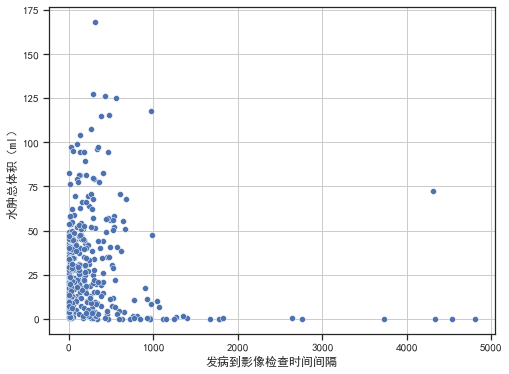

In [149]:
# 双变量分析：综合散点图
# 横坐标 检测到发病的时间点
# 纵坐标 检测时对应的水肿体积（ml）
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol)
plt.grid(True)
plt.xlabel("发病到影像检查时间间隔（h）")
plt.ylabel("水肿总体积（ml）")
# plt.xscale('log')

plt.show()

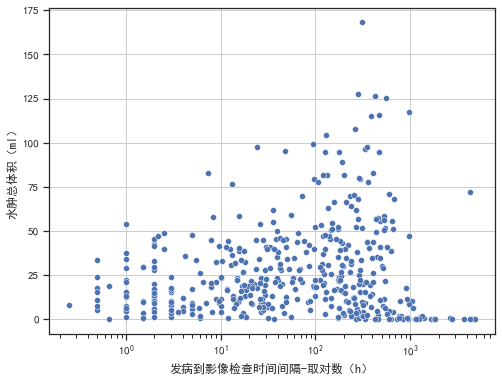

In [162]:
# 横轴取 log 之后，与分样本观察的规律一致
plt.close()

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol)

plt.grid(True)
plt.xlabel("发病到影像检查时间间隔-取对数（h）")
plt.ylabel("水肿总体积（ml）")
plt.xscale('log')

plt.show()

说明水肿与发病时间间隔间应该存在潜在关联，并且是较为普适的。   
下面进行回归分析

## 时序数据回归分析   
样本点数量：450

In [11]:
time_np = np.array(time).reshape(-1, 1)
vol_np = np.array(vol).ravel()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

### 传统回归分析   
1. 线性回归模型
2. 多项式回归模型
3. 非线性回归模型
    - 指数函数
    - 对数函数
    - 幂函数
4. 广义线性模型
    - 线性回归
    - 逻辑回归
    - 泊松回归

In [14]:
# 对原始数据进行排序
new_index = np.argsort(time_np, axis=0)
time_sorted = time_np[new_index].reshape(-1, 1)
vol_sorted = vol_np[new_index].reshape(-1, 1)
# 加上微小值，防止除零错误
vol_sorted_log = np.log(vol_sorted + 1e-10)

#### 线性回归

In [16]:
# 线性回归
linear_model = LinearRegression()
linear_model.fit(time_sorted, vol_sorted_log)

y_pred = linear_model.predict(time_sorted)

# 计算均方误差
residuals = vol_sorted_log - y_pred
mse = mean_squared_error(vol_sorted_log, y_pred)
r2 = r2_score(vol_sorted_log, y_pred)
# print("残差：", residuals)
print("均方误差：", mse)
print("R2:", r2)

均方误差： 15.529131134719645
R2: 0.3324047190681805


/home/yangxs/.conda/envs/cvtask/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yangxs/.conda/envs/cvtask/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30149 (\N{CJK UNIFIED IDEOGRAPH-75C5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yangxs/.conda/envs/cvtask/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yangxs/.conda/envs/cvtask/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yangxs/.conda/envs/cvtask/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20687 (\N{CJK

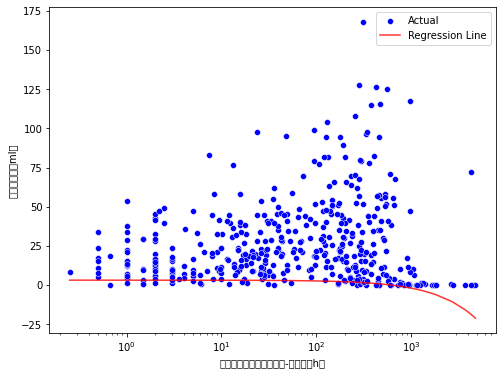

In [17]:
# 绘制回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol, color='blue', label='Actual')
plt.plot(time_sorted, y_pred, color='red', label='Regression Line', alpha=0.8)
plt.xlabel('发病到影像检查时间间隔-取对数（h）')
plt.xscale('log')
plt.ylabel('水肿总体积（ml）')
plt.legend()

plt.show()

#### 多元线性回归

In [285]:
# 多元线性回归

mse_l = []
r2_l = []

def poly_linear_r(degree):
    poly_feat = PolynomialFeatures(degree=degree)
    train_feat = poly_feat.fit_transform(time_sorted)

    # 创建线性回归模型
    linear_model = LinearRegression()

    # 训练模型
    linear_model.fit(train_feat, vol_sorted_log)

    y_pred = linear_model.predict(train_feat)

    # 计算指标
    mse = mean_squared_error(vol_sorted_log, y_pred)
    r2 = r2_score(vol_sorted_log, y_pred)
    
    return (mse, r2, y_pred)
    
for d in range(1, 10):
    mse, r2, _ = poly_linear_r(d)
    mse_l.append(mse)
    r2_l.append(r2)

<Figure size 576x432 with 0 Axes>

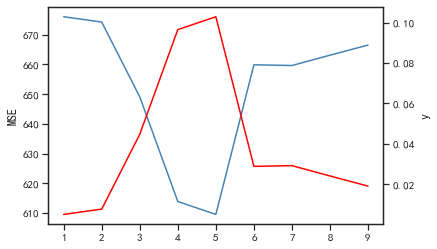

In [293]:
# degree参数挑选
plt.close()

plt.figure(figsize=(8, 6))

degree_range = [d for d in range(1, 10)]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# mse 线
sns.lineplot(x=degree_range, y=mse_l, ax=ax1, color='steelblue')
ax1.set_ylabel('MSE')
# r2 线
sns.lineplot(x=degree_range, y=r2_l, ax=ax2, color='red')
ax2.set_ylabel('R2')

plt.xlabel('X')
plt.ylabel('y')

plt.show()

In [298]:
mse, r2, y_pred = poly_linear_r(5)

In [299]:
print("mse:", mse, "\tr2:", r2)

mse: 609.53738590038 	r2: 0.102875172891985


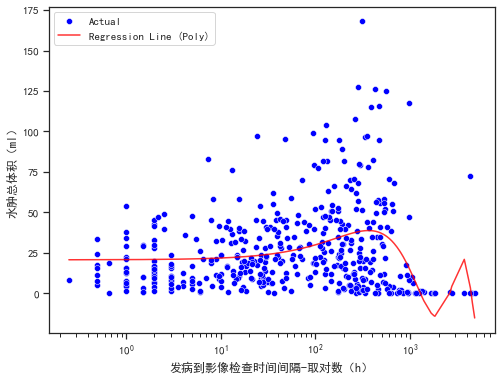

In [300]:
# 绘制多元回归线
plt.close()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=time, y=vol, color='blue', label='Actual')
plt.plot(time_sorted, y_pred, color='red', label='Regression Line (Poly, degree=5)', alpha=0.8)
plt.xlabel('发病到影像检查时间间隔-取对数（h）')
plt.ylabel('水肿总体积（ml）')
plt.xscale('log')
plt.legend()

plt.show()

#### ARMA模型

In [304]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
# from arch import arch_model

In [305]:
from statsmodels.tsa.stattools import adfuller

In [306]:
import statsmodels.api as sm

In [307]:
dta = sm.datasets.sunspots.load_pandas().data

In [308]:
dta

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [309]:
data_df = pd.DataFrame({""})

In [ ]:
model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()
predictions = model_fit.predict(start=start_index, end=end_index)

### 机器学习

In [226]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#### 支持向量回归

rbf会过拟合；深度学习方法一律排除   
rbf的R^2会到0.94

In [224]:
# 随机测试一组参数
svr = SVR(kernel='linear', C=1e3, gamma=0.1)
svr.fit(time_np, vol_np)

y_pred = svr.predict(time_np)
r2 = r2_score(vol_np, y_pred)
print("R2 Score:", r2)

R2 Score: -2.7180693649647454


In [216]:
# 网格搜索
grid = {'C': [1e2, 1e3, 1e4, 1e5],
              'gamma': [0.01, 0.1, 1, 10,100]}

svr = SVR(kernel='linear')

grid_search = GridSearchCV(svr, grid, scoring='r2')
grid_search.fit(time_np, vol_np)

# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Parameters:  {'C': 100.0, 'gamma': 100}
Best R2 Score:  -0.0524468557851383


In [217]:
# 最优参数过拟合
svr = SVR(kernel='rbf', C=100, gamma=100)
svr.fit(time_np, vol_np)

y_pred = svr.predict(time_np)
r2 = r2_score(vol_np, y_pred)
print("R2 Score:", r2)

R2 Score: 0.9409460685316113


In [214]:
svr = SVR(kernel='rbf', C=1e4, gamma=0.1)
svr.fit(time_np, vol_np)

y_pred = svr.predict(time_np)
r2 = r2_score(vol_np, y_pred)
print("R2 Score:", r2)

R2 Score: 0.6954199731083057


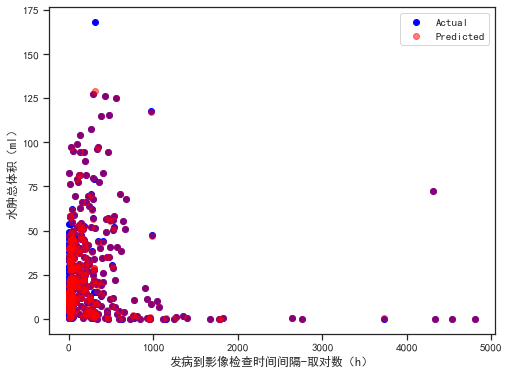

In [221]:
plt.close()

plt.figure(figsize=(8, 6))
plt.scatter(time, vol, color='blue', label='Actual')
plt.scatter(time, y_pred, color='red', label='Predicted', alpha=0.5)
plt.xlabel('发病到影像检查时间间隔-取对数（h）')
plt.ylabel('水肿总体积（ml）')
plt.legend()

plt.show()